**Scania Air Pressure System Failures Prediction**

In this challange we are asked to predict if there is truck APS failure based on the sensor telemetry data.



**READING DATA**

First I will load basic libraries and raw data. Additional libraries I will be loading as necessary to increase readibility.

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("../Data/aps_failure_training_set.csv", na_values="na")
testingData = pd.read_csv("../Data/aps_failure_test_set.csv", na_values="na")
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


From a visual inspection of raw data it is obvious that some columns contain missing values. The first column named "class" is our target set (labels).

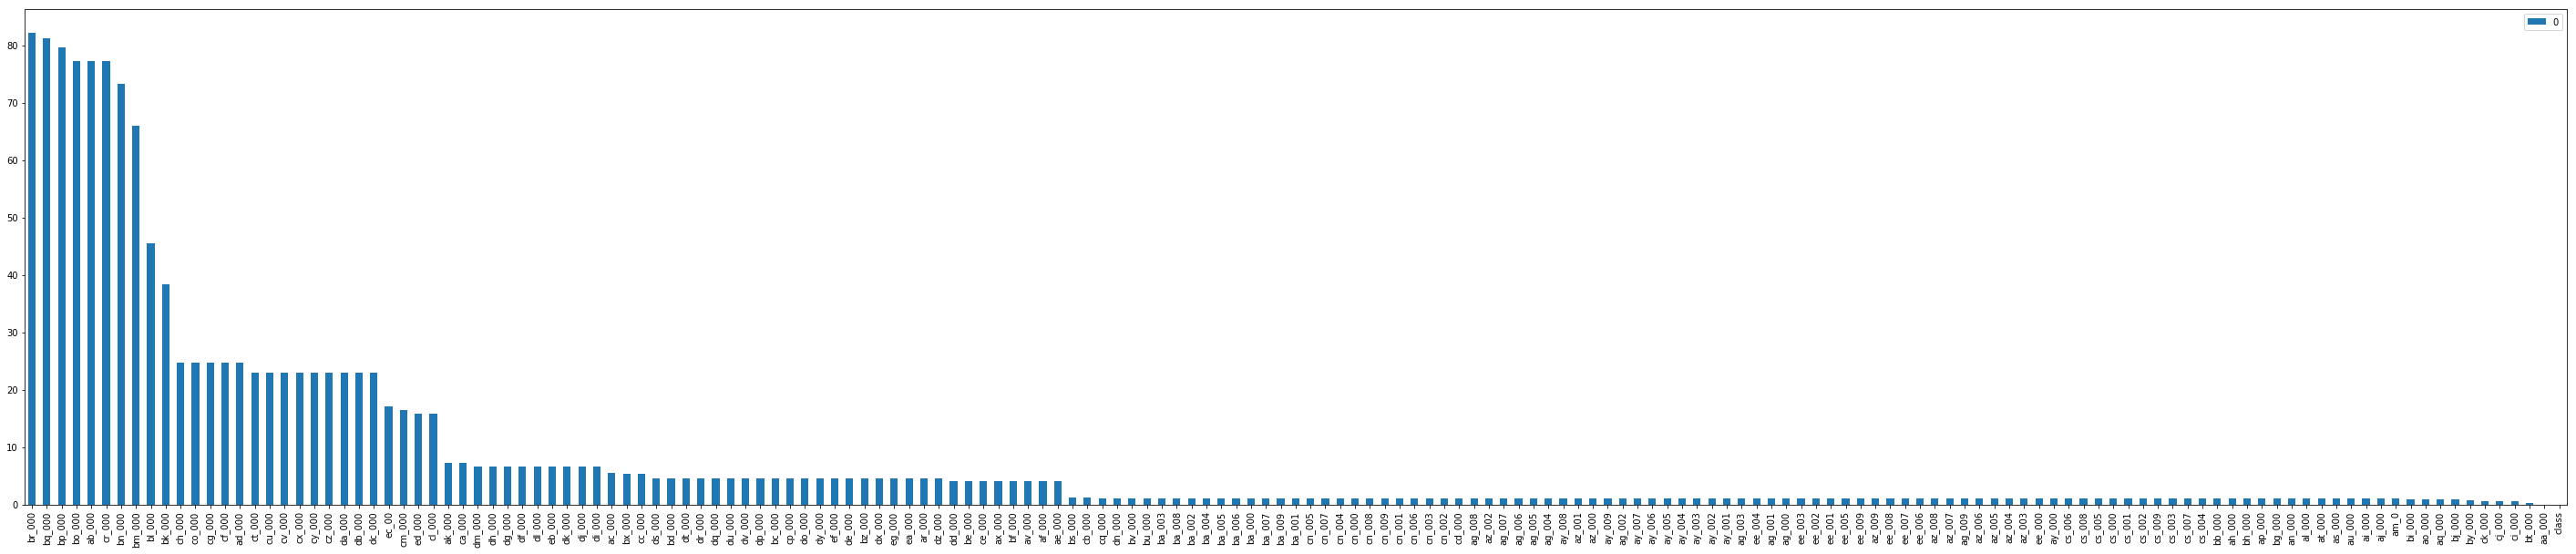

In [2]:
missing = data.isna().sum().div(data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing.plot.bar(figsize=(50,10))

Graph above shows that we have significant amount of missing data. In this approach to modelling I am not going to drop any columns and check what best results I can get.

In [3]:
missing[missing[0]>80]

,0
br_000,82.106667
bq_000,81.203333


**DEALING WITH MISSING DATA**

In [15]:
X = data.drop(["class","br_000","bq_000"], axis=1)
y = data.loc[:,"class"]
y = pd.get_dummies(y).drop("neg",axis=1)

Filling missing data with a mean.

In [5]:
X.fillna(X.mean(), inplace=True)

**DATA STANDARISATION**

I am going to use the Support Vector Machine Classifier and it requires standarisation of data.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


**CREATING CUSTOM SCORER**

Here I will create a custom scorer accoring to the database guidelines.

In [7]:
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix

def my_scorer(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp+500*fn
    return cost

my_func = make_scorer(my_scorer, greater_is_better=False)

**PCA AND PARAMETERS OPTIMISATION PIPELINED**

I will chain PCA and classification model with a pipeline to perform a grid search optimisation. In the cell below I will use Support Vector Machine Classifier (SVC). 

In [8]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = SVC(probability = False, class_weight="balanced", gamma="auto")
pca = PCA()

pipe = Pipeline(steps=[("pca",pca),("clf",clf)])

param_grid = {
    'pca__n_components': range(10,26),
    'clf__C': [0.2, 0.3,0.4,0.5],
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=3, return_train_score=False, scoring = my_func, n_jobs=-1, verbose=3)
search.fit(X_scaled, np.ravel(y))

# %% Plotting best classificator
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 17.4min
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a m

Best parameter (CV score=-16486.667):
{'clf__C': 0.3, 'pca__n_components': 24}


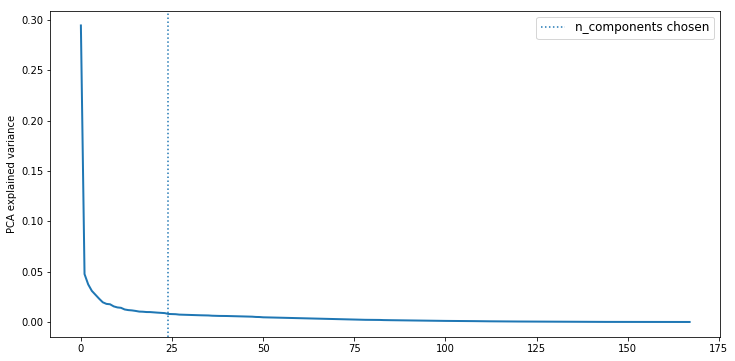

In [9]:
pca.fit(X_scaled)

fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

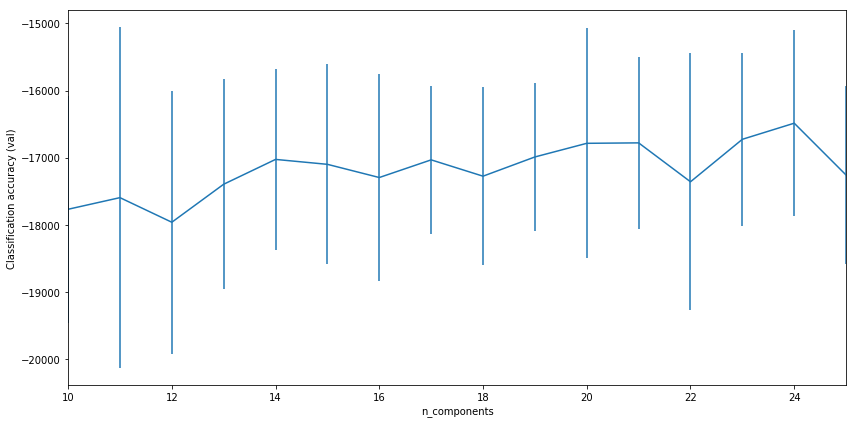

In [10]:
fig, ax1 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))

results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

# Testing Purpose

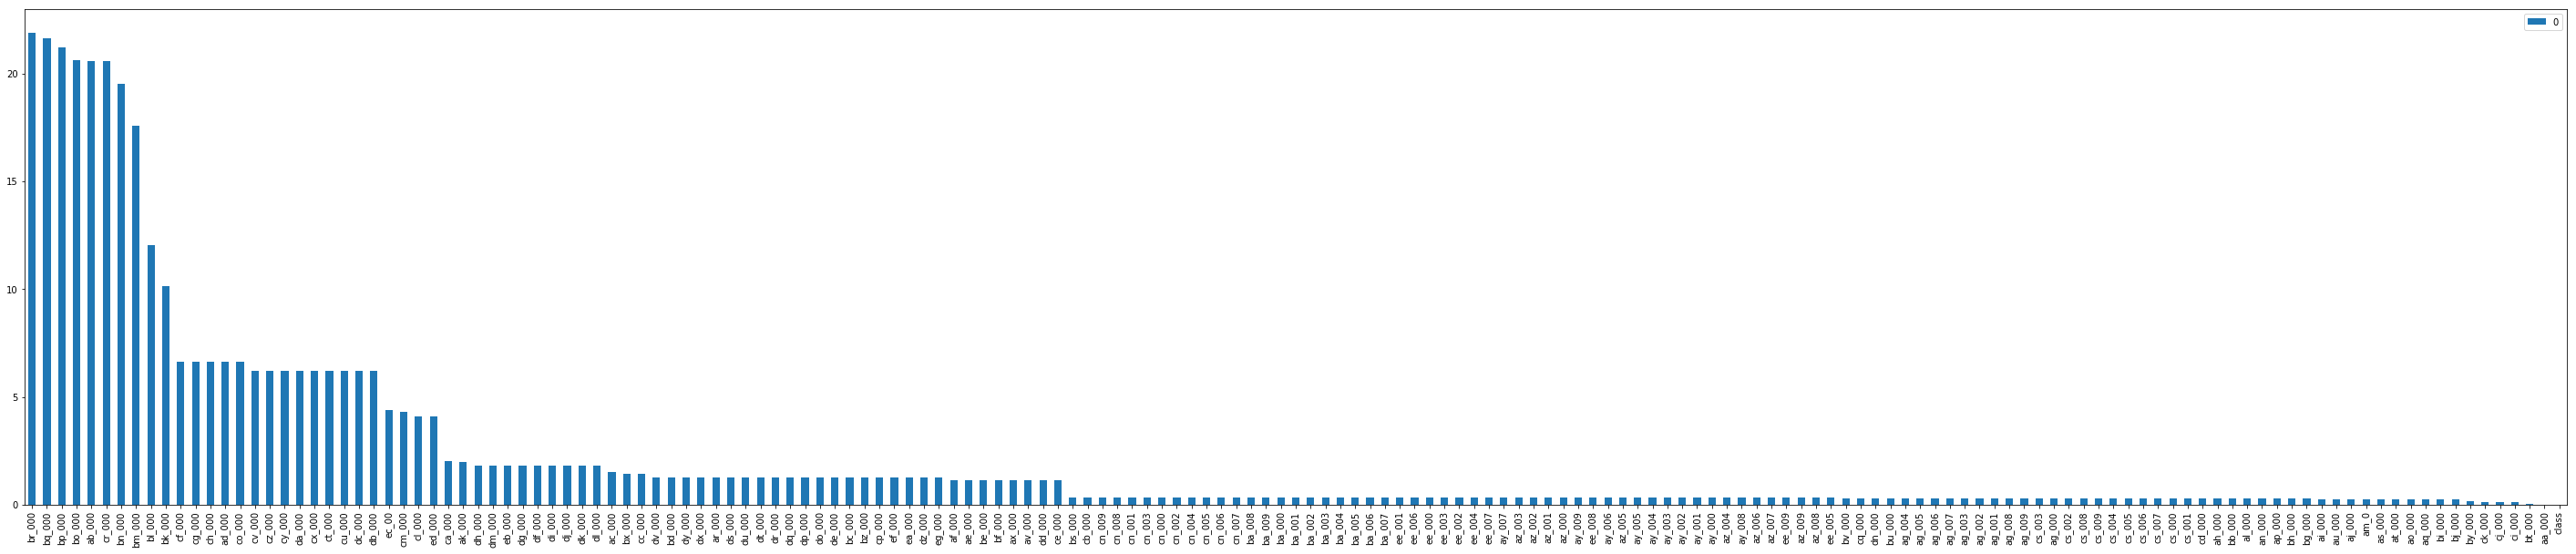

In [18]:
missing_test = testingData.isna().sum().div(data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_test.plot.bar(figsize=(50,10))

Graph above shows that we have significant amount of missing data. In this approach to modelling I am not going to drop any columns and check what best results I can get.

In [19]:
missing_test[missing_test[0]>80]

,0


**DEALING WITH MISSING DATA**

In [21]:
X_test = testingData.drop(["class","br_000","bq_000"], axis=1)
y_test = testingData.loc[:,"class"]
y_test = pd.get_dummies(y_test).drop("neg",axis=1)

Filling missing data with a mean.

In [22]:
X_test.fillna(X_test.mean(), inplace=True)

In [28]:
y_test.size

16000

In [31]:
gridPrediction = search.predict(X_test)

In [33]:
gridPrediction

16000

In [36]:
my_scorer(y_test,gridPrediction)

156250